# Paper ST Sloping - 32 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.metrics import specificity_score
import random
import time

In [2]:
THREADS_TO_USE = 4

## Load dataset

In [3]:
data = pd.read_csv('../dataset/st_dataset_32beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,...,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807,-0.008983,NSR
1,e0106,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,...,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060,-0.004790,NSR
2,e0106,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,...,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271,-0.005162,NSR
3,e0106,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,...,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778,-0.000208,NSR
4,e0106,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,...,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157,-0.002940,NSR


In [4]:
data['label'].replace("ST-", "ST", inplace=True)
data['label'].replace("ST+", "ST", inplace=True)

In [5]:
data['label'].value_counts()

NSR    13090
ST      3982
Name: label, dtype: int64

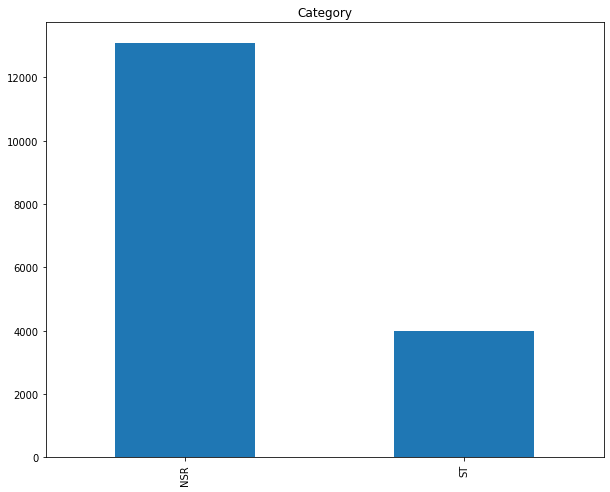

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.237685,0.106778,0.074513,0.049017,0.164754,-0.043134,0.066522,-0.005085,0.007374,...,-0.101746,-0.045780,-0.057627,-0.042941,-0.032342,-0.074357,-0.049488,-0.067248,-0.103371,-0.094220
dw_2,0.237685,1.000000,0.838142,0.502265,0.189472,0.396750,-0.511218,-0.362148,0.007304,0.027974,...,-0.110800,0.180227,0.237271,0.173162,0.054253,0.037079,0.134331,0.012952,-0.116243,-0.070422
dw_3,0.106778,0.838142,1.000000,0.702042,0.287089,0.241283,-0.555562,-0.499643,0.012774,0.016280,...,-0.199872,0.154880,0.275167,0.120954,-0.052022,0.066460,0.043879,-0.017784,-0.133008,-0.045069
dw_4,0.074513,0.502265,0.702042,1.000000,0.873295,-0.014716,-0.278260,-0.278962,0.008457,0.006416,...,-0.152384,0.071768,0.115122,0.067878,-0.039769,0.051749,0.026810,-0.031360,-0.111832,-0.044385
dw_5,0.049017,0.189472,0.287089,0.873295,1.000000,-0.124955,-0.026226,-0.049222,0.001954,0.000388,...,-0.063773,0.011881,-0.006932,0.044290,0.004779,0.016077,0.019832,-0.039655,-0.062702,-0.031614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.074357,0.037079,0.066460,0.051749,0.016077,-0.150115,0.112145,0.135231,-0.002228,0.004135,...,-0.135005,-0.212171,-0.056621,0.041745,0.071561,1.000000,0.024910,0.010580,-0.361983,-0.228896
cfr_13,-0.049488,0.134331,0.043879,0.026810,0.019832,0.073383,-0.006052,0.015178,0.006819,-0.001301,...,0.163738,0.044522,-0.209958,-0.266707,0.009957,0.024910,1.000000,0.238508,0.156749,-0.141656
cfr_14,-0.067248,0.012952,-0.017784,-0.031360,-0.039655,-0.001977,0.028472,0.029755,0.005549,-0.006743,...,0.121685,0.230485,0.039279,-0.173963,-0.282881,0.010580,0.238508,1.000000,0.221302,-0.128261
cfr_15,-0.103371,-0.116243,-0.133008,-0.111832,-0.062702,0.047377,0.081087,0.044183,0.001850,-0.014418,...,0.293341,0.157001,-0.089191,-0.138736,-0.062263,-0.361983,0.156749,0.221302,1.000000,0.344573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_226', 'fft_256', 'fft_143', 'fft_159', 'fft_240', 'fft_137', 'fft_247', 'mfw_16', 'fft_132', 'fft_212', 'fft_181', 'fft_161', 'fft_234', 'fft_190', 'fft_231', 'fft_149', 'fft_233', 'fft_146', 'fft_179', 'fft_171', 'mfw_12', 'fft_227', 'mfw_7', 'fft_155', 'fft_157', 'fft_180', 'fft_183', 'fft_172', 'fft_253', 'fft_139', 'fft_220', 'fft_136', 'fft_186', 'fft_168', 'fft_176', 'fft_178', 'fft_169', 'fft_236', 'fft_202', 'fft_173', 'fft_167', 'fft_153', 'fft_145', 'fft_150', 'fft_170', 'fft_207', 'fft_222', 'fft_191', 'fft_188', 'fft_134', 'fft_177', 'fft_200', 'fft_194', 'fft_225', 'fft_203', 'mfw_15', 'mfw_5', 'fft_252', 'fft_249', 'fft_242', 'fft_148', 'fft_211', 'fft_187', 'fft_205', 'fft_214', 'fft_156', 'fft_228', 'fft_162', 'fft_160', 'fft_250', 'mfw_13', 'fft_199', 'fft_217', 'fft_164', 'fft_147', 'fft_255', 'fft_154', 'cfr_16', 'fft_248', 'fft_166', 'fft_213', 'fft_130', 'fft_219', 'fft_158', 'fft_238', 'fft_175', 'fft_210', 'mfw_9', 'fft_197', 'fft_204', 'fft_229', 'fft_251'

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_25
fft_26
fft_29
fft_30
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 75


### Visualization best features

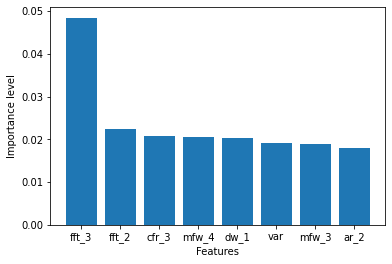

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,-1.009483,...,0.017932,0.038860,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807
1,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,2.486222,...,0.014723,0.042961,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060
2,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,-2.150671,...,0.006243,0.051369,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271
3,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,-4.289119,...,0.014157,0.055342,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778
4,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,-1.067047,...,0.034652,0.022510,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report(y_true=y_test_dec, y_pred=y_pred_dec, output_dict=True)
    specificity = specificity_score(y_true=y_test_dec, y_pred=y_pred_dec, average="weighted")

    acc = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']


    # save result in result_df
    result_df = result_df.append({
        "accuracy": acc,
        "specificity": specificity,
        "precision": precision,
        "recall": recall,
        "f1": f1
     }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Accuracy", acc, "precision", precision, "specificity", specificity, "recall", recall, "f1", f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 4.212051868438721 s
Accuracy 0.9256222547584187 precision 0.9255560986170169 specificity 0.8628407220371807 recall 0.9256222547584187 f1 0.9255887565463421
#---------------------#
#---------------------#
2 of 1000 - 4.180998802185059 s
Accuracy 0.9238653001464129 precision 0.9240752763410198 specificity 0.863967513924863 recall 0.9238653001464129 f1 0.9239665539462553
#---------------------#
#---------------------#
3 of 1000 - 4.315043210983276 s
Accuracy 0.9206442166910688 precision 0.9208195835800198 specificity 0.8608938135515702 recall 0.9206442166910688 f1 0.920729350542878
#---------------------#
#---------------------#
4 of 1000 - 4.314999580383301 s
Accuracy 0.927086383601757 precision 0.9276820943679455 specificity 0.8759090291584455 recall 0.927086383601757 f1 0.9273544421932957
#---------------------#
#---------------------#
5 of 1000 - 4.344000339508057 s
Accuracy 0.9326500732064422 precision 0.9324785774775338 specificity 0.8756608284136

In [18]:
result_df.head(10)

,accuracy,specificity,precision,recall,f1
0,0.925622,0.862841,0.925556,0.925622,0.925589
1,0.923865,0.863968,0.924075,0.923865,0.923967
2,0.920644,0.860894,0.920820,0.920644,0.920729
3,0.927086,0.875909,0.927682,0.927086,0.927354
4,0.932650,0.875661,0.932479,0.932650,0.932561
5,0.924451,0.858007,0.923717,0.924451,0.924003
6,0.928843,0.870629,0.928875,0.928843,0.928859
7,0.933821,0.879870,0.933764,0.933821,0.933792
8,0.923865,0.873226,0.925158,0.923865,0.924406
9,0.932064,0.879961,0.932318,0.932064,0.932184


In [19]:
print("######## Total ########")
print("Accuracy", result_df["accuracy"].mean())
print("Precision", result_df["precision"].mean())
print("Specificity",  result_df["specificity"].mean())
print("Recall",  result_df["recall"].mean())
print("F1",  result_df["f1"].mean())

result_df.to_csv('result/bin_32beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9262717423133238
Precision 0.9262897980456046
Specificity 0.8670761481935747
Recall 0.9262717423133238
F1 0.9262485454814935
